In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy as sp

Step 1: Define the Lattice Structure
- Lattice Shape (number indicates a dipole exists, 0 indicates no dipole)
- Spin states (each dipole will be represented by an entry in the lattice with a value of either +1 or -1)

Step 2: Hamiltonian Construction

- The hamiltonian describes the total energy of the system, accounting for interactions between neightboring spins. The enerrgy interaction between two neightboring spins is typically proportional to the product of their spin states (i.e. $H = -J\sum S_iS_j$, where $J$ is a coupling constant and $S_i$ and $S_j$ are the spin states of neighbors.)
- Once lattice is constructed, we need to filter out which dipoles are neighbors. For a 2D array, a dipole can interact with its left, right, top, below, top right, top left, bottom right, bottom left neighbors.

Step 3: Calculate total energy

- Use $H = -J\sum S_iS_j$ formula and sum up the energy contributions from every dipole in the lattice to determine the "total energy"

In [2]:
def lattice_generator(x, N, M):
    bits = N * M
    # Convert integer x to binary representation, zero-padded to fit N*M bits
    if len(bin(x)[2:]) > bits:
        sys.exit("Error: Maximum is greater than lattice shape. Please try a lower maximum.")
    return np.array([int(i) for i in bin(x)[2:].zfill(bits)])

def hamiltonian_boundary(spin_lattice, J):
    total_energy = 0
    rows, cols = spin_lattice.shape

    for i in range(rows):
        for j in range(cols):
            # Consider only if the current index is a spin
            if spin_lattice[i][j] != 0:
                # Neighbors with periodic boundary conditions
                neighbors = [
                    ((i + 0) % rows, (j + 1) % cols),  # Right
                    ((i + 1) % rows, (j + 0) % cols),  # Down
                    ((i + 1) % rows, (j + 1) % cols),  # Down-Right
                ]
                for ni, nj in neighbors:
                    total_energy += -J * spin_lattice[i][j] * spin_lattice[ni][nj]

    return total_energy

# Lattice size
N = 3
M = 3
maximum = 511 #2^9-1

bit_string = lattice_generator(0, N, M) 
spin_lattice = bit_string.reshape(N, M)
spin_lattice = np.where(spin_lattice == 0, -1, 1) # Convert 0 to 1 (up spin) and 1 to -1 (down spin)

J = 1
total_energy = hamiltonian_boundary(spin_lattice, J)

print("Spin Lattice:\n", spin_lattice)
print("\nTotal Energy (periodic boundary) :", total_energy)
print("\nBit String: ", bit_string)

Spin Lattice:
 [[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]

Total Energy (periodic boundary) : -27

Bit String:  [0 0 0 0 0 0 0 0 0]


In [3]:
# Lattice size
N = 6
M = 9
maximum = 511541382

bit_string = lattice_generator(maximum, N, M) #101011110
spin_lattice = bit_string.reshape(N, M)
spin_lattice = np.where(spin_lattice == 0, -1, 1) # Convert 0 to 1 (up spin) and 1 to -1 (down spin)

J = 1
total_energy = hamiltonian_boundary(spin_lattice, J)

print("Spin Lattice:\n", spin_lattice)
print("\nTotal Energy (periodic boundary) :", total_energy)
print("\nBit String: ", bit_string)

Spin Lattice:
 [[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1  1  1]
 [ 1  1 -1 -1  1  1  1  1  1]
 [-1  1  1 -1 -1 -1 -1 -1 -1]
 [-1  1 -1 -1 -1 -1  1  1 -1]]

Total Energy (periodic boundary) : -62

Bit String:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0
 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0]


In [4]:
def lowest_energy(N, M):
    maximum = (1 << (N*M)) - 1
    bit_strings = []
    lattice_list = []
    count = 0
    minimum_energy = float('inf')  # Initialize to a large value
    
    for i in range(maximum):
        bit_string = lattice_generator(i, N, M)
        spin_lattice = bit_string.reshape(N, M)
        spin_lattice = np.where(spin_lattice == 0, -1, 1)  # Convert 0 to -1 (spin down), 1 to 1 (spin up)
        J = -1
        total_energy = hamiltonian_boundary(spin_lattice, J)
        
        # Check if the current configuration has lower or equal energy
        if total_energy < minimum_energy:
            minimum_energy = total_energy
            bit_strings = [bit_string]  # Reset with the new lowest
            lattice_list = [i]
            count = 1
    
        elif total_energy == minimum_energy:
            bit_strings.append(bit_string)
            lattice_list.append(i)
            count += 1
    
    return count, bit_strings, minimum_energy, lattice_list

# Lattice size
N = 2
M = 2

count, bitstrings, minimum_energy, latticelist = lowest_energy(N,M)


print("The minimum energy found was %i. It was found %i times."%(minimum_energy, count))
print("The given bit string integer(s) were:", latticelist)

The minimum energy found was -4. It was found 6 times.
The given bit string integer(s) were: [3, 5, 6, 9, 10, 12]


In [5]:
def correlated_spin_probabilities(bitstrings, N, M):
    """
    Compute the spin-spin correlation function ⟨s_i s_j⟩ for all spin pairs using the Z Pauli matrix.
    
    Parameters:
        bitstrings (list of np.array): List of binary spin lattices (each reshaped to (N, M)).
        N (int): Number of rows in the lattice.
        M (int): Number of columns in the lattice.
    
    Returns:
        np.array: Correlation matrix of shape (N, M, N, M).
    """
    num_configs = len(bitstrings)
    correlation_matrix = np.zeros((N, M, N, M))

    for bitstring in bitstrings:
        spin_lattice = np.where(bitstring.reshape(N, M) == 0, -1, 1)  # Convert to ±1

        # Compute spin-spin correlation ⟨s_i s_j⟩
        for i in range(N):
            for j in range(M):
                for k in range(N):
                    for l in range(M):
                        # Only count (i, j), (k, l) when (i, j) <= (k, l)
                        if (i < k) or (i == k and j <= l):
                            correlation_matrix[i, j, k, l] += spin_lattice[i, j] * spin_lattice[k, l]
                            # Symmetrize the matrix
                            correlation_matrix[k, l, i, j] = correlation_matrix[i, j, k, l]

    # Normalize by number of configurations
    correlation_matrix = correlation_matrix / num_configs

    return correlation_matrix

Spin Lattice:
 [[-1 -1]
 [ 1  1]]

Bit String:  [0 0 1 1]
Spin Lattice:
 [[-1  1]
 [-1  1]]

Bit String:  [0 1 0 1]
Spin Lattice:
 [[-1  1]
 [ 1 -1]]

Bit String:  [0 1 1 0]
Spin Lattice:
 [[ 1 -1]
 [-1  1]]

Bit String:  [1 0 0 1]
Spin Lattice:
 [[ 1 -1]
 [ 1 -1]]

Bit String:  [1 0 1 0]
Spin Lattice:
 [[ 1  1]
 [-1 -1]]

Bit String:  [1 1 0 0]
The minimum energy found was -4. It was found 6 times.
The given bit string integer(s) were: [3, 5, 6, 9, 10, 12]

Spin-Spin Correlation Matrix:
[[[[ 1.         -0.33333333]
   [-0.33333333 -0.33333333]]

  [[-0.33333333  1.        ]
   [-0.33333333 -0.33333333]]]


 [[[-0.33333333 -0.33333333]
   [ 1.         -0.33333333]]

  [[-0.33333333 -0.33333333]
   [-0.33333333  1.        ]]]]


C:\Users\dscot\AppData\Local\Temp\ipykernel_29636\2360583840.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for the colorbar


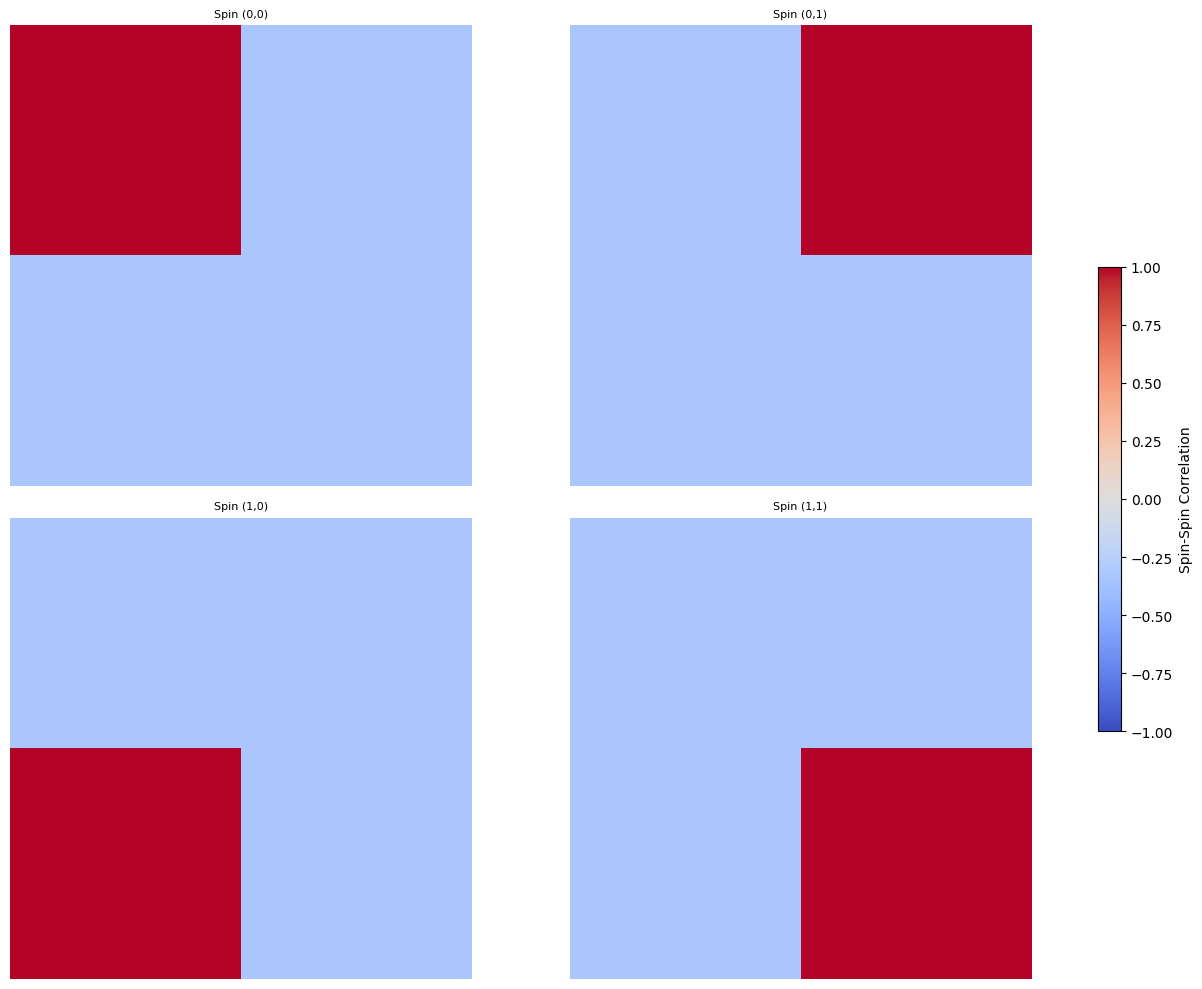

In [ ]:
def plot_correlation_matrices(N, M, correlation_matrix):
    
    fig, axes = plt.subplots(N, M, figsize=(15, 10))  # Create a grid of subplots
    
    for i in range(N):
        for j in range(M):
            ax = axes[i, j]  # Get the subplot for this position
            cax = ax.imshow(correlation_matrix[i, j], cmap='coolwarm', vmin=-1, vmax=1)
            ax.set_title(f"Spin ({i},{j})", fontsize=8)
            ax.axis('off')  # Hide axis for better visualization
    
    # Add a colorbar outside the grid
    fig.colorbar(cax, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04, label="Spin-Spin Correlation")
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for the colorbar
    plt.show()

# Lattice size
N = 2
M = 2

count, bitstrings, minimum_energy, latticelist = lowest_energy(N, M)

for string in latticelist:

    bit_string = lattice_generator(string, N, M) #101011110
    spin_lattice = bit_string.reshape(N, M)
    spin_lattice = np.where(spin_lattice == 0, -1, 1) # Convert 0 to 1 (up spin) and 1 to -1 (down spin)
    print("Spin Lattice:\n", spin_lattice)
    print("\nBit String: ", bit_string)

print(f"The minimum energy found was {minimum_energy}. It was found {count} times.")
print("The given bit string integer(s) were:", latticelist)

correlation_matrix = correlated_spin_probabilities(bitstrings, N, M)
print("\nSpin-Spin Correlation Matrix:")
print(correlation_matrix)

plot_correlation_matrices(N, M, correlation_matrix)


The minimum energy found was -9. It was found 42 times.
The given bit string integer(s) were: [84, 85, 86, 92, 94, 116, 117, 161, 163, 165, 169, 171, 177, 181, 212, 213, 225, 229, 241, 244, 245, 266, 267, 270, 282, 286, 298, 299, 330, 334, 340, 342, 346, 348, 350, 394, 395, 417, 419, 425, 426, 427]

Spin-Spin Correlation Matrix:
[[[[ 1.         -0.33333333 -0.33333333]
   [-0.33333333 -0.33333333  0.61904762]
   [-0.33333333  0.61904762 -0.33333333]]

  [[-0.33333333  1.         -0.33333333]
   [ 0.61904762 -0.33333333 -0.33333333]
   [-0.33333333 -0.33333333  0.61904762]]

  [[-0.33333333 -0.33333333  1.        ]
   [-0.33333333  0.61904762 -0.33333333]
   [ 0.61904762 -0.33333333 -0.33333333]]]


 [[[-0.33333333  0.61904762 -0.33333333]
   [ 1.         -0.33333333 -0.33333333]
   [-0.33333333 -0.33333333  0.61904762]]

  [[-0.33333333 -0.33333333  0.61904762]
   [-0.33333333  1.         -0.33333333]
   [ 0.61904762 -0.33333333 -0.33333333]]

  [[ 0.61904762 -0.33333333 -0.33333333]
 

C:\Users\dscot\AppData\Local\Temp\ipykernel_29636\2360583840.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space for the colorbar


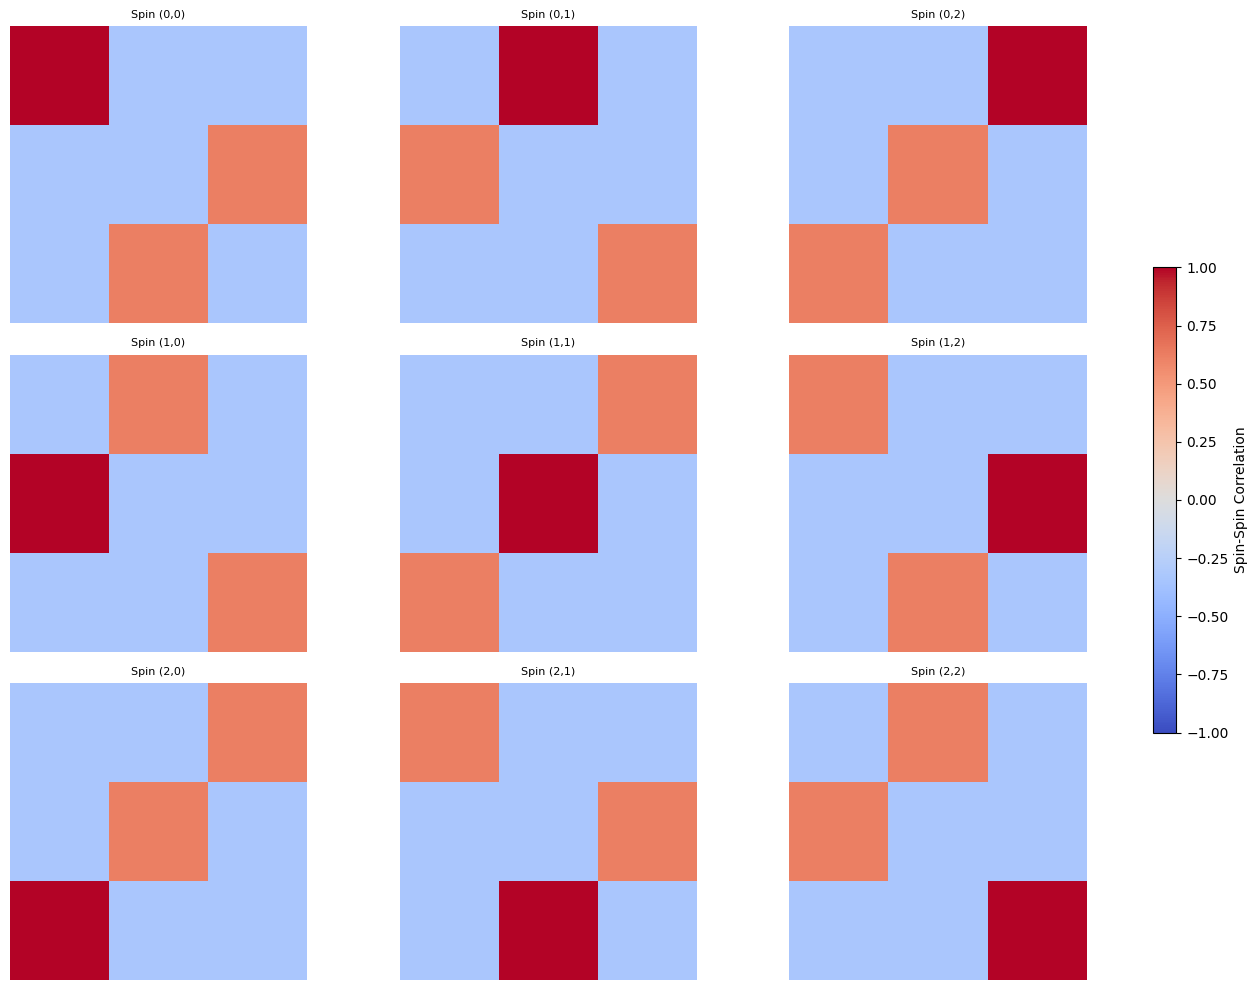

In [7]:
# Lattice size
N = 3
M = 3

count, bitstrings, minimum_energy, latticelist = lowest_energy(N, M)

print(f"The minimum energy found was {minimum_energy}. It was found {count} times.")
print("The given bit string integer(s) were:", latticelist)

correlation_matrix = correlated_spin_probabilities(bitstrings, N, M)
print("\nSpin-Spin Correlation Matrix:")
print(correlation_matrix)

plot_correlation_matrices(N, M, correlation_matrix)


In [9]:
# Lattice size
N = 4
M = 4

count, bitstrings, minimum_energy, latticelist = lowest_energy(N, M)

print(f"The minimum energy found was {minimum_energy}. It was found {count} times.")
print("The given bit string integer(s) were:", latticelist)

correlation_matrix = correlated_spin_probabilities(bitstrings, N, M)
print("\nSpin-Spin Correlation Matrix:")
print(correlation_matrix)

The minimum energy found was -16. It was found 42 times.
The given bit string integer(s) were: [3855, 5965, 7710, 11565, 11915, 14025, 15420, 19275, 19735, 21845, 21850, 21925, 21930, 23125, 23130, 23205, 23210, 26985, 27795, 29905, 30840, 34695, 35630, 37740, 38550, 42325, 42330, 42405, 42410, 43605, 43610, 43685, 43690, 45800, 46260, 50115, 51510, 53620, 53970, 57825, 59570, 61680]

Spin-Spin Correlation Matrix:
[[[[ 1.         -0.33333333  0.23809524 -0.33333333]
   [-0.33333333 -0.33333333  0.04761905  0.04761905]
   [ 0.23809524  0.04761905  0.23809524  0.04761905]
   [-0.33333333  0.04761905  0.04761905 -0.33333333]]

  [[-0.33333333  1.         -0.33333333  0.23809524]
   [ 0.04761905 -0.33333333 -0.33333333  0.04761905]
   [ 0.04761905  0.23809524  0.04761905  0.23809524]
   [-0.33333333 -0.33333333  0.04761905  0.04761905]]

  [[ 0.23809524 -0.33333333  1.         -0.33333333]
   [ 0.04761905  0.04761905 -0.33333333 -0.33333333]
   [ 0.23809524  0.04761905  0.23809524  0.04761

In [ ]:
new cell and stuff